# Duration Prediction Model

## Analysis

In [2]:
!python -V

Python 3.9.19


### Import Packages

In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/home/tsimpson_unix/ml_ops_zoomcamp/w2_experiment_tracking/mlruns/1', creation_time=1716205390239, experiment_id='1', last_update_time=1716205390239, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Read Data

In [5]:
df = pd.read_csv('../data/green_tripdata_2021-01.csv')

/tmp/ipykernel_696286/1973399759.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/green_tripdata_2021-01.csv')


### Review Data

In [6]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.5,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.5,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.5,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.5,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.0,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,0.0,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,0.0,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,0.0,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,0.0,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN


In [7]:
df.dtypes

VendorID                 float64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID               float64
PULocationID               int64
DOLocationID               int64
passenger_count          float64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type             float64
trip_type                float64
congestion_surcharge     float64
dtype: object

### EDA and feature generation

In [8]:
# Convert datetime columns to datetime dtype
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [9]:
df.dtypes

VendorID                        float64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [10]:
# Set filter so we only have trip_type code 2 which corresponds to dispatch
# We do not want street-hail data
# df = df[df.trip_type == 2]
# We are commenting this out because it was causing weird data distributions 

In [11]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.5,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.5,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.5,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.5,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.0,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,0.0,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,0.0,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,0.0,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,0.0,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN


In [12]:
# Calculate duration
df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime)

In [13]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,0 days 00:16:00
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,0 days 00:09:00
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,0 days 00:04:00
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,0 days 00:42:00


In [14]:
# Duration is not very useful in this form, conver to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [15]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
4,2.0,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,16.000000
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,9.000000
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,4.000000
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,42.000000


In [16]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [17]:
# There were many odd low durations so let's take a look at the percentiles
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [18]:
((df.duration >= 1) & (df. duration <= 50)).mean()

0.9508873729057216

In [19]:
# Only 50% of trip durations are between 1 and 50 minutes which seems strange
# Because of this we commented out the filtering of only type 2 rides which made this number look much more accurate

In [20]:
df = df[(df.duration >= 1) & (df. duration <= 60)]

In [21]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2.0,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
7,2.0,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,NaN,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,NaN,2021-01-15 10:35:00,2021-01-15 10:51:00,NaN,NaN,3,147,NaN,5.97,17.01,...,0.0,0.00,0.00,NaN,0.3,17.31,NaN,NaN,NaN,16.000000
76514,NaN,2021-01-15 10:25:00,2021-01-15 10:34:00,NaN,NaN,242,213,NaN,3.83,27.27,...,0.0,2.75,0.00,NaN,0.3,30.32,NaN,NaN,NaN,9.000000
76515,NaN,2021-01-15 10:16:00,2021-01-15 10:20:00,NaN,NaN,181,181,NaN,0.45,12.89,...,0.0,2.75,0.00,NaN,0.3,15.94,NaN,NaN,NaN,4.000000
76516,NaN,2021-01-15 10:16:00,2021-01-15 10:58:00,NaN,NaN,244,72,NaN,22.21,50.67,...,0.0,2.75,6.12,NaN,0.3,59.84,NaN,NaN,NaN,42.000000


In [22]:
# Let's take a look at categorical variables and split out the numericals

In [23]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [24]:
# Check dtype of categoricals
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [25]:
# We can convert these via encoding so they can be used in a model
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_696286/2496045046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [27]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

### Model creation

In [28]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [29]:
# This vectorizer will transform the categorical features into a vector so categoricals can be used in the model
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [30]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [31]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [32]:
target = 'duration'
y_train = df[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_696286/3831492026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_696286/3831492026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


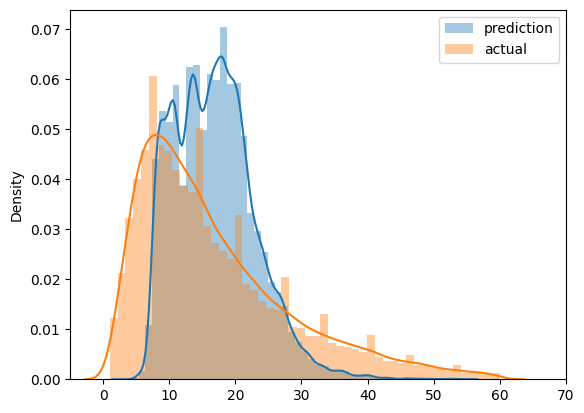

In [35]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.xlim(-5, 70)

plt.legend()

plt.show()

In [36]:
mean_squared_error(y_train, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829497

In [37]:
# On average our model is wrong by about 10 minutes which isn't good but it's a start

### Model improvement

In [38]:
# First lets combine all of our cleaning and feature generation into a pre-processing function we can execute

def read_dataframe(filename):
    df = pd.read_csv(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df. duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    #numerical = ['trip_distance'] #numerical not needed in this function since we don't do preprocessing on it

    df[categorical] = df[categorical].astype(str)
    
    return df

In [39]:
# Now we can easily create train and validation sets since pre-processing has been condensed into a function
df_train = read_dataframe('../data/green_tripdata_2021-01.csv')
df_val = read_dataframe('../data/green_tripdata_2021-02.csv')

/tmp/ipykernel_696286/3151220129.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [40]:
len(df_train), len(df_val)

(73908, 61921)

In [41]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [42]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2.0,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,NaN,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2.0,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2.0,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,NaN,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2.0,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,NaN,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2.0,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,NaN,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,NaN,2021-02-26 08:46:00,2021-02-26 08:59:00,NaN,NaN,167,247,NaN,1.47,14.55,...,0.00,0.0,NaN,0.3,17.60,NaN,NaN,NaN,13.000000,167_247
64568,NaN,2021-02-26 08:56:00,2021-02-26 09:10:00,NaN,NaN,89,123,NaN,2.87,20.22,...,0.00,0.0,NaN,0.3,23.27,NaN,NaN,NaN,14.000000,89_123
64569,NaN,2021-02-26 08:46:00,2021-02-26 09:07:00,NaN,NaN,127,166,NaN,4.74,24.94,...,0.00,0.0,NaN,0.3,30.74,NaN,NaN,NaN,21.000000,127_166
64570,NaN,2021-02-26 08:17:00,2021-02-26 08:51:00,NaN,NaN,42,137,NaN,7.63,41.81,...,0.00,0.0,NaN,0.3,44.86,NaN,NaN,NaN,34.000000,42_137


In [43]:
# Now let's combine all the post-processing and include the steps for our validation set

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts) # Note we just transform not fit_transform here we don't want learning to take place

In [44]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.7587152053176585

In [46]:
# Now that we have a baseline let's try other models such as Lasso
# Lasso introduces some regularization

lr = Lasso()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


12.212583224318816

In [47]:
"""# Worse with default but we can change parameters

lr = Lasso(alpha = 0.005) # Note I tested multiple alpha values
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)"""

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.696342127127648

In [49]:
# Let's try another model Ridge regression another form of regulrizated linear regression
with mlflow.start_run():

    # mlflow.set_tag("tag1", "tag2") # You can use this to add developer name and other useful tags
    # Here is an example of parameter logging where we do basic data "versioning"
    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.csv")
    mlflow.log_param("val-data-path", "../data/green_tripdata_2021-02.csv")

    alpha = 0.01
    mlflow.log_param("alpha", alpha) # Keep track of each alpha we pass

    lr = Ridge(alpha) # Note I tested multiple alpha values
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/tsimpson_unix/anaconda3/envs/ml-ops-zoomcamp-01/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [86]:
# We are going to add to and manipulate features above which won't be evident scrolling through the notebook so I will note it here
# 1. Adding PU_DO feature to combine pickup and dropoff locations and removed them individually
# This improved the model accuracy from ~10% to ~7%

In [ ]:
# Experiment tracking demo

import xgboost as xgb

"""
fmin - finds minimum of output
tpe - algorithm to control logic
hp - library that contains methods to define ranges for each hyperparameter
STATUS_OK - at end of each run tells the system it is ok
Trials - keeps track of information from each run
scope - determines range of type int
"""
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# First we must set the train and validation data to the correct format for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params, # Specify parameters which are input variables in this case
            dtrain=train, # Specify training dataset
            num_boost_round=1000, # Set maximum iterations
            evals=[(valid, "validation")], # Specify evaluation dataset
            early_stopping_rounds=50 # If 50 iterations go without improvement early stop is done
        )

        y_pred=booster.predict(valid) # Once model trained, make predictions on validation set
        rmse=mean_squared_error(y_val, y_pred, squared=False) # RMSE to determine performance
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
    
search_space = {
    # Controls depth of trees (converts float to int inside)
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    # Learning rate from exp(-3), exp(0) basically [0.05 to 1]
    'learning_rate': hp.loguniform('learning_rate',-3,0),
    # Using similar loguniform logic as above for alpha and weight
    'reg_alpha': hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda': hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective': 'reg:linear',
    'seed':42,
}

best_result = fmin(
    # Pass all of the above to the fmin function which will minimize output to find best method
    fn=objective, # Define the function we created above
    space=search_space, # Pass search space
    algo=tpe.suggest, # Optimization algorithm we are running
    max_evals=50,
    trials=Trials() # Where information of each run is stored
)   

In [90]:
# Since our Linear Regression model performed okay let's export it
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out) # Save vectorizer and model